# Bayesian A/B Testing

## Introduction

### A/B Testing

A/B Testing is used to compare several items and select the best option based on a quantitative metric. 

Some applications include:

+ Testing a new medicine to see if it works. We test if it works by having a control group vs treatment group.
+ Designing several options for a website to see which one brings the most conversion rate.
+ Comparing the ratio of failures of hardware from two vendors.

### Frequentist vs Bayesian approach

Frequentist approach:
+ Frequentist assume there is a **true value** for a given population parameter. 
+ Inference exists to estimate it to a given level of confidence: $\hat{\theta} = \text{argmax}_\theta P(X | \theta)$.

Bayesian approach:
+ Bayesian assume the given population parameter is a **random variable**. 
+ Inference exits to calculate its **posterior probability distribution** from the data we have collected: $P(\theta | X)$.

Sampling methods:
+ Importance sampling
+ Markov chain Monte Carlo ([MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)), typically used to approximate large multi-dimensional integrals

___

## Limits of Frequentist Statistics

### General limitations

+ Terms and definitions are hard to understand for non-technical - and even many technical - people.
+ The experiment needs to run for the appropriate sample size before we can draw conclusions without running the risk of false positives.
+ Failing to reject the null hypothesis is NOT the same as accepting it. Maybe the sample size was just to small or the variance very large.

### Estimate of a population parameter

We use the CLT to estimate the value of a population paramater to a given level of confidence. The variance of the sampling distribution of the sample statistic is a Gaussian Distribution of variance $\sigma^2 / N$, where $\sigma^2$ is the variance of the population paramater.

Drawbacks:
+ if $\sigma$ is large, you need large samples to get an accurate view
+ we usually don't know $\sigma$, but we can use the sample variance $\hat{\sigma}$ instead (or use the t-distribution for more precise CI)

### Limits of p-value

The example below shows the evolution of the p-value of Chi-Square tests comparing two ads over time. We see that the p-value can vary dramatically from one experiment to the next:

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

class Clickthrough:
    
    def __init__(self, ctr_a, ctr_b, n_visits):
        '''
        init the true ctr of two ad campaigns
        and the empty df that will store the observed ctr
        and the p-value of the chi-square test after each visit
        '''
        self.ctr_a = ctr_a
        self.ctr_b = ctr_b
        self.visits = 0
        self.visits_a = np.array([0, 0])
        self.visits_b = np.array([0, 0])
        self.pval = np.zeros(n_visits)

    def visit(self):
        '''
        simulates a visit that have a self.true_ctr likelihood
        of doing a ctr
        '''
        # random visit result
        self.visits += 1
        click_a = (np.random.random() < self.ctr_a)
        click_b = (np.random.random() < self.ctr_b)
        
        # save results
        self.visits_a += [click_a, 1 - click_a]
        self.visits_b += [click_b, 1 - click_b]
        
        # calculate p-value of chi-square test
        self.calculate_pval()
      
    def calculate_pval(self):
        '''
        calculate the p-value of a chi-square test checking if ad_A and ad_B have 
        the same ctr
        '''
        if self.visits > 10:
            _, pval, _, _ = chi2_contingency(np.array([self.visits_a, self.visits_b]), correction=False)
            self.pval[self.visits - 1] = pval
        
    def display_results(self):
        '''
        display the respective clicks of ad_A and ad_B in a nice way
        '''
        df = pd.DataFrame(
            np.array([self.visits_a, self.visits_b]), 
            index=['ad_A', 'ad_B'],
            columns=['Click', 'No Click']
        )
        return df
    
    def plot_pvalues(self):
        plt.plot(self.pval)
        plt.plot(np.ones(self.pval.shape[0]) * 0.05)
        axes = plt.gca()
        axes.set_ylim([0,1])
        plt.show()

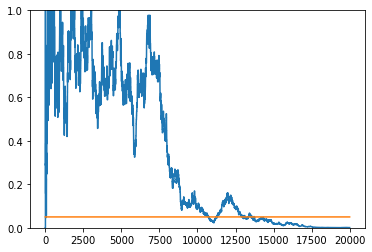

In [196]:
n_visits = 20000
ctr = Clickthrough(0.1, 0.11, 20000)
for visits in range(20000):
    ctr.visit()
    
ctr.plot_pvalues()

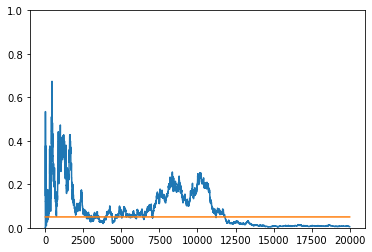

In [197]:
n_visits = 20000
ctr = Clickthrough(0.1, 0.11, 20000)
for visits in range(20000):
    ctr.visit()
    
ctr.plot_pvalues()

___

## Probability & Bayes Theorem

### Definitions

Probability is the likelihood of a given event occuring for each experiment of a given sample space.

Draw $r$ times from a population of $n$ (with or without repetition):
+ Permutations: order matters
+ Combination: order does not matter

<br>

Relationship between events:
+ **Marginal** probability: P(A)
+ **Conditional** probability P(B|A): probability of B given A
+ **Joint** probability P(A ∩ B): Intersection of two events A and B 
+ Union of two events P(A ∪ B): A or B
+ Complement of an event P(A'): not A

Note: 
+ rule of substraction: P(A) = 1 - P(A')
+ rule of addition: P(A ∪ B) = P(A) + P(B) - P(A ∩ B)
+ rule of multiplication: P(A ∩ B) = P(A) P(B|A)
+ rule of multiplication: P(A ∩ B ∩ C) = P(A) P(B|A) P(C|AB)

<br>

Events are:
+ Independant when the outcome of one has no effect on others
+ Dependant when the outcome of one has some effect on others (example: draw without replacement)

Note for independant events: 
+ P(B|A) = P(B) so P(A ∩ B) = P(A) P(B)

### Bayes Theorem

We know that P(A ∩ B) = P(A) P(B|A) = P(B) P(A|B). It means that (Bayes Theorem):
+ P(A|B) = P(B|A) $\times$ P(A) / P(B)

Where:
+ P(B) = sum [ P(B|A) $\times$ P(A) ] for all A _(or integral for continuous data)_

Notes:
+ probabilities equal to one when considering the space of random variables. The sum of P(B|A) will be equal to one for each given value of A.
+ P(B) does not depend on A, so $\text{argmax}_A P(A|B) = \text{argmax}_A P(B|A) P(A)$

### Curse of Dimensionality

**Joint probabilities** increase **exponentially** with the number of variables:
+ requires more computational power
+ requires more data to get accurate estimates
+ leads to exponentially small probabilities (computers having finite precision lead to underflow issues)
+ log probability can be used to mitigate this issue

___

## Bayes Theorem Examples

### Diagnostic Tools

Bayes Theorem determines the probability of a parameter given a certain event. It is used extensively in fields with diagnostic tools that are only effective to a certain degree.

+ a company learns that 0.2% of their products are defective.
+ they buy a diagnotic tool that is correct 99% of the time.
+ if a part is diagnosed as defective, what is the probability that is is _really_ defective?

Let's use the following notations:
+ OK when not defective, NOK when defective
+ DI when diagnosed as not defective, NDI when diagnosed as defective

Bayes Theorem states that:

+ P(NOK|NDI) = P(NDI|NOK) P(NOK) / P(NDI)

Where:
+ P(NDI|NOK) = 0.99 - true positive
+ P(NOK) = 0.002
+ P(NDI) = P(NDI|NOK) x P(NOK) + P(NDI|OK) x P(OK) = true positive + false positive = 0.99 x 0.002 + 0.01 x 0.998

It means that:
+ P(NOK|NDI) = 16.5%

If we run a second test that is _also_ positive on the same product, we can update the probability of it being _really_ defective using the result of the first test:

+ P(NOK) = 16.5%
+ P(NOK|NDI) = 95.1%

### Coin tosses

We want to toss a fair coin 200 times. After 20 tosses, we have 15H and 5T. What is the expected end result?

+ it is not 100H and 100T, because we have already tossed 20 times.
+ it has become 15 + (200 - 20) / 2 = 105H and 5 + (200 - 20) / 2 = 95T.

### Monty Hall Problem

A show has three doors to choose from, and behind one of them is a car. After you choose one door, the host reveals another one and asks you if you want to switch. Should you do it?

Let's imagine you choose door N°1 and the host opens door at door you did not pick, for instance N°2. You want to calculate the probabilities of P(D1 | H2) and P(D3 | H2), where P(Dx) is the probability that the car is behind door N°x and H2 the door that the host has chosen.

+ P(Dx | H2) = P(H2 | Dx) * P(Dx) / P(H2)
+ P(H2) = P(H2 | D1) * P(D1) + P(H2 | D2) * P(D2) + P(H2 | D3) * P(D3) 

Let's look at P(H2 | Dx):
+ P(H2 | D1) = 0.5   - the host could have chosen either door N°2 or door N°3
+ P(H2 | D2) = 0     - the host would not reveal the car
+ P(H2 | D3) = 1     - the host would always avoid revealing the door that the contestant chose if possible

A simple calculation gives P(D1 | H2) = 1/3 and P(D3 | H2) = 2/3: you should switch doors.

___

## Bayesian Statistics

### Explore vs Exploit

The Multi-Armed Bandits states that you are in a casino playing slots. Three machines have three different pay rates: 30%, 20%, and 10% respectively.

Frequentist Statistics would:
+ perform a Chi-Square test after $N$ trials
+ calculate the p-value
+ identify if one of them is significantly better than the others

But if you were to test it, you would:
+ try each machine a few times
+ collect data
+ adapt your strategy to your conclusions

A typical strategy would be to:
+ **explore** at random to collect more data, 
+ or **exploit** the one that seems to give the best results

### Beta Distribution

We want to measure the clickthrough rate of our website. The more data we have, the more confident we are of its value. In other words, the confidence interval narrows when the sample size increases.

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

class Clickthrough:
    
    def __init__(self, true_ctr):
        '''
        init the ctr class true ctr
        and observations (total and actual ctr)
        '''
        self.true_ctr = true_ctr
        self.obs_visits = 0
        self.obs_clicks = 0
        self.obs_ctr = 0
        
        self.x = np.linspace(0, 1, 200)
        self.betas = {}
        
    def beta(self):
        '''
        saves the beta distribution of shape parameters
        self.obs_clicks and self.obs_visits
        '''
        y = beta.pdf(self.x, self.obs_clicks, self.obs_visits)
        self.betas[self.obs_visits] = [self.obs_ctr, y]

    def visit(self):
        '''
        simulates a visit that have a self.true_ctr likelihood
        of doing a ctr
        '''
        # random visit result
        self.obs_visits += 1
        visit_result = (np.random.random() < self.true_ctr)
        if visit_result:
            self.obs_clicks += 1

        # current observed ctr
        self.obs_ctr = self.obs_clicks / self.obs_visits
        
        # saves beta distribution
        if self.obs_visits in [0, 5, 10, 25, 50, 200, 500]:
            self.beta()
        
    def plot(self):
        '''
        show beta distributions
        '''

        # init plot fig
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        for (obs_visits, [obs_ctr, obs_beta]) in self.betas.items():
            ax.plot(self.x, obs_beta, label = '{} visits - obs_ctr: {:.2}'.format(obs_visits, obs_ctr))
            ax.legend()

        plt.show()

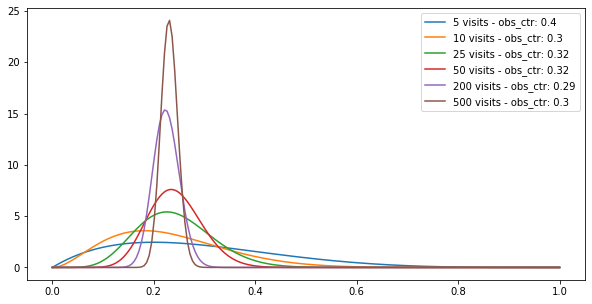

In [54]:
ctr = Clickthrough(0.3) 
for visits in range(501):
    ctr.visit()
    
ctr.plot()

### CTR Example

In [207]:
#chi-square example
import pandas as pd
import scipy.stats as stats 

csv_path = r'..\courses material\Bayesian Machine Learning\advertisement_clicks.csv'
ctr = pd.read_csv(csv_path, dtype={'advertisement_id': str, 'action': int})

# build df
df = ctr.groupby('advertisement_id').agg({'action': ['count', 'sum']})
df.columns = ['Total', 'Click']
df['No Click'] = df['Total'] - df['Click']
df = df.drop(columns = ['Total'])

display(df)

# we reject the null hypothesis of no impact: ad B is better than A
chi2, p, _, _ = stats.chi2_contingency(df)
print('Chi-Square test: {:.3} - p-value: {:.3}'.format(chi2, p)) 

,Click,No Click
advertisement_id,,
A,304,696
B,372,628


Chi-Square test: 10.0 - p-value: 0.00154
